In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Juste un pattern arbitraire, qu'on peut changer par ce que l'on veut"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repéter le même pattern à chaque période"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [56]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
#series1 = trend(time, 0.1)
amplitude1 = 40
slope1 = 0.05
noise_level1 = 5


#series2 = trend(time, 0.5)
amplitude2 = 30
slope2 = 0.2
noise_level2 = 10
baseline2 = 4
series1 = baseline + trend(time, slope1) + seasonality(time, period=365, amplitude=amplitude1)
series2 = baseline2 + trend(time, slope2) + seasonality(time, period=365, amplitude=amplitude2)

series1 += noise(time, noise_level1, seed=42)
series2 += noise(time, noise_level2, seed=42)

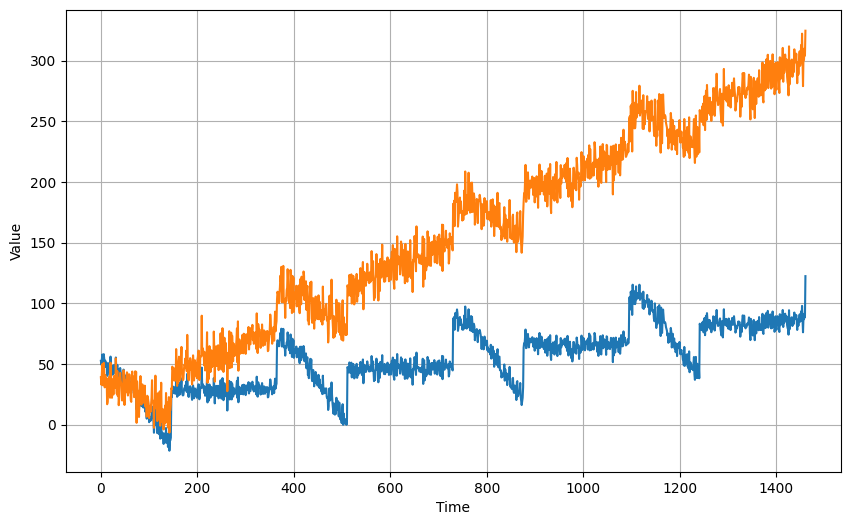

In [57]:
plt.figure(figsize=(10, 6))
plot_series(time, series1)
plot_series(time, series2)
plt.show()

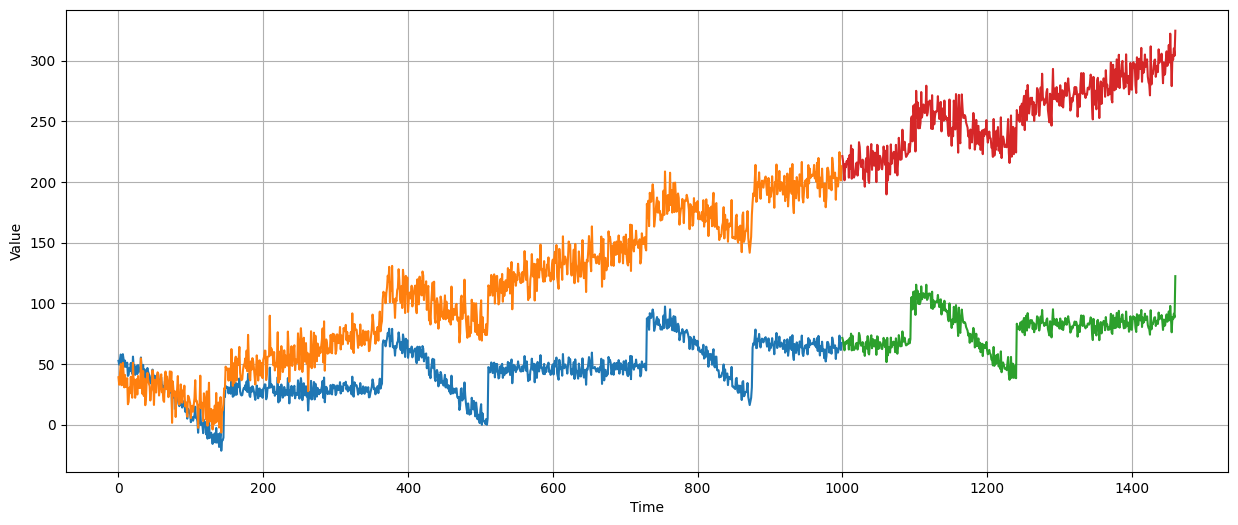

In [58]:
split_time = 1000

# Training set
time_train = time[:split_time]
x1_train = series1[:split_time]
x2_train= series2[:split_time]

# Validation set
time_valid = time[split_time:]
x1_valid = series1[split_time:]
x2_valid = series2[split_time:]

# Dessin
plt.figure(figsize=(15, 6))
plot_series(time_train, x1_train)
plot_series(time_train, x2_train)
plot_series(time_valid, x1_valid)
plot_series(time_valid, x2_valid)
plt.show()

In [59]:
naive_forecast1 = series1[split_time - 1:-1]
naive_forecast2 = series2[split_time - 1:-1]

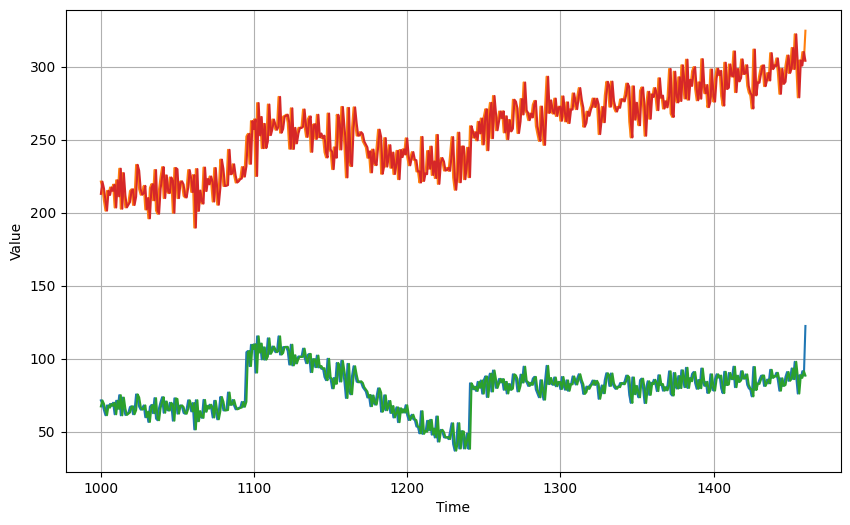

In [60]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x1_valid)
plot_series(time_valid, x2_valid)
plot_series(time_valid, naive_forecast1)
plot_series(time_valid, naive_forecast2)

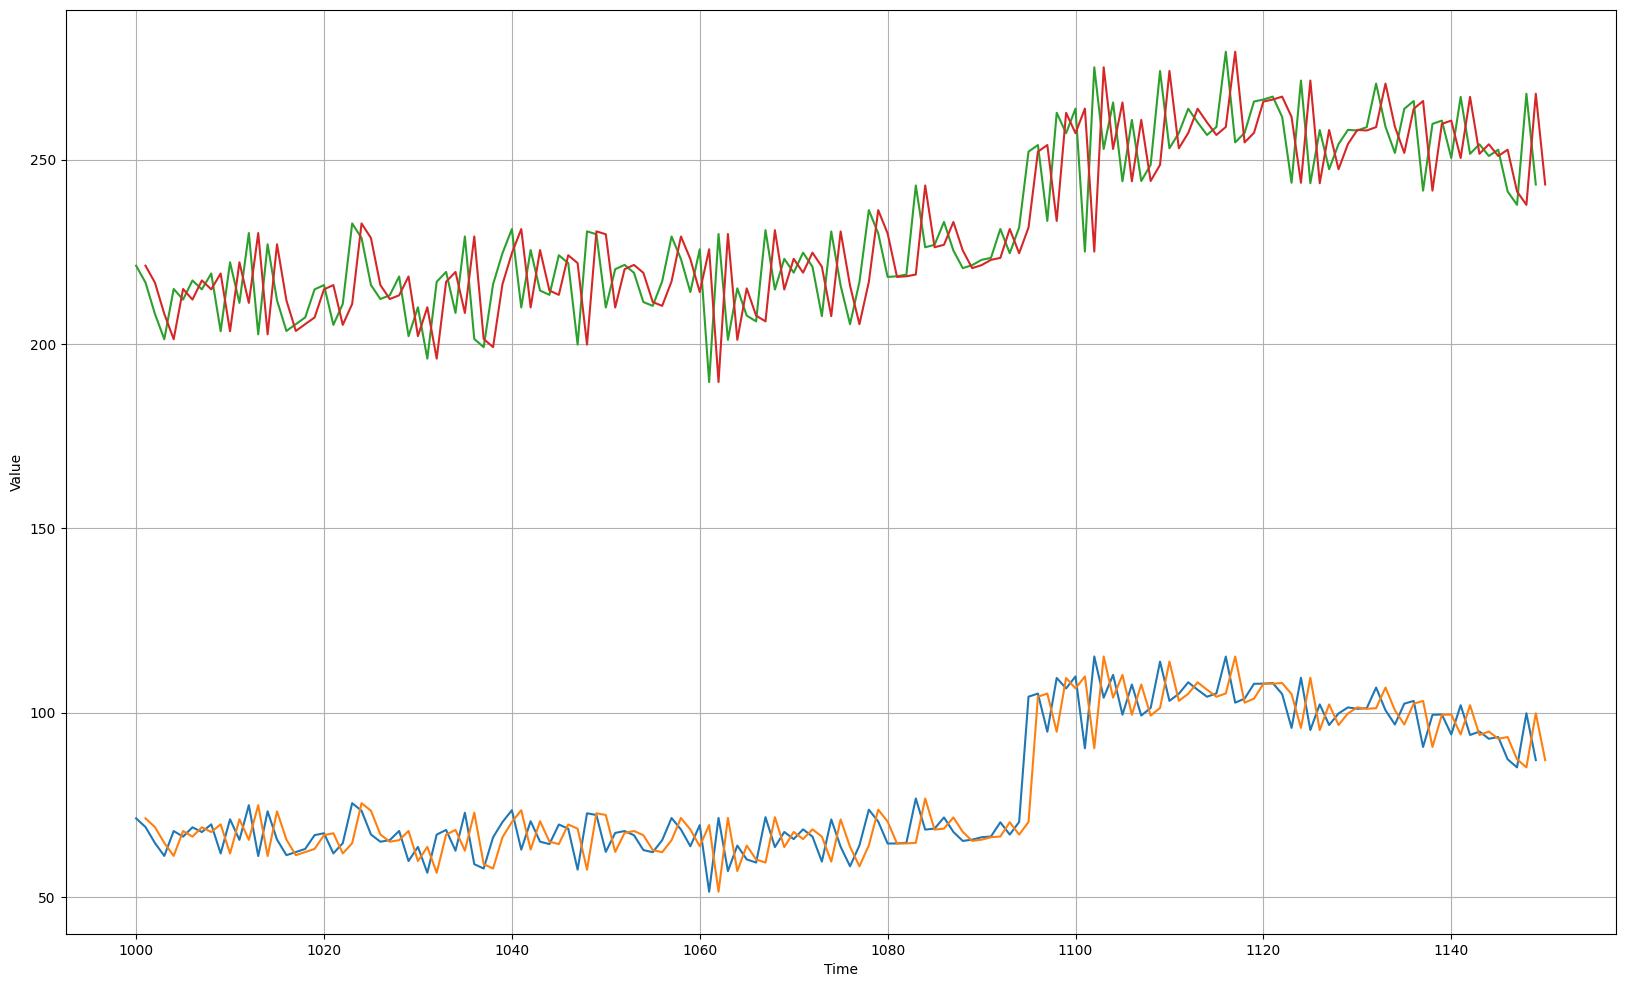

In [61]:
plt.figure(figsize=(20, 12))
plot_series(time_valid, x1_valid, start=0, end=150)
plot_series(time_valid, naive_forecast1, start=1, end=151)
plot_series(time_valid, x2_valid, start=0, end=150)
plot_series(time_valid, naive_forecast2, start=1, end=151)

In [62]:
print("\nL'erreur MSE pour naive forecast1:", keras.metrics.mean_squared_error(x1_valid, naive_forecast1).numpy())
print("\nL'erreur MAE pour naive forecast1:",keras.metrics.mean_absolute_error(x1_valid, naive_forecast1).numpy())
print("-----------------------------------")
print("\nL'erreur MSE pour naive forecast2:", keras.metrics.mean_squared_error(x2_valid, naive_forecast2).numpy())
print("\nL'erreur MAE pour naive forecast2:",keras.metrics.mean_absolute_error(x2_valid, naive_forecast2).numpy())



L'erreur MSE pour naive forecast1: 61.827534

L'erreur MAE pour naive forecast1: 5.937908
-----------------------------------

L'erreur MSE pour naive forecast2: 213.97668

L'erreur MAE pour naive forecast2: 11.5319395


In [47]:
def moving_average_forecast(series, window_size):
  """Prévoire la moyenne des dernières valeurs.
      Si window_size=1, cela équivaut à une prévision naïve"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

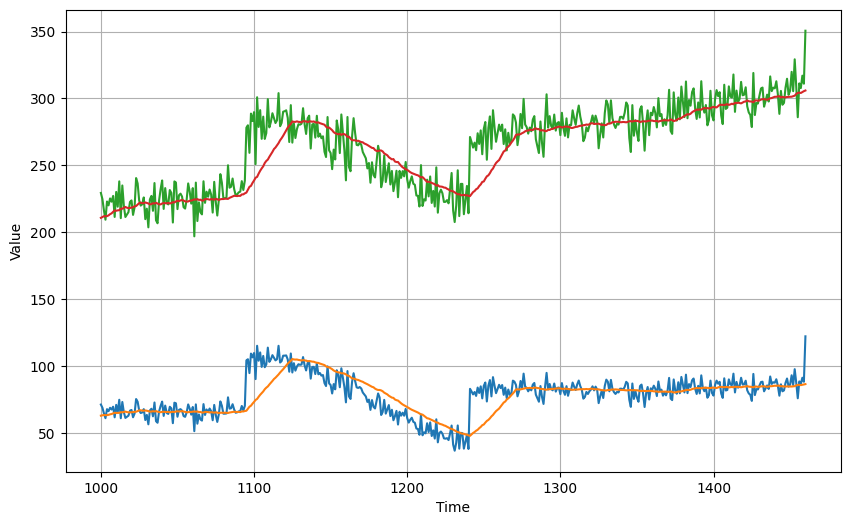

In [48]:
moving_avg1 = moving_average_forecast(series1, 30)[split_time - 30:]
moving_avg2= moving_average_forecast(series2, 30)[split_time - 30:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x1_valid)
plot_series(time_valid, moving_avg1)
plot_series(time_valid, x2_valid)
plot_series(time_valid, moving_avg2)

In [49]:
print("\nL'erreur MSE pour la moyenne mobile:", keras.metrics.mean_squared_error(x1_valid, moving_avg1).numpy())
print("\nL'erreur MAE pour la moyenne mobile:", keras.metrics.mean_absolute_error(x1_valid, moving_avg1).numpy())

print("--------")

print("\nL'erreur MSE pour la moyenne mobile:", keras.metrics.mean_squared_error(x2_valid, moving_avg2).numpy())
print("\nL'erreur MAE pour la moyenne mobile:", keras.metrics.mean_absolute_error(x2_valid, moving_avg2).numpy())


L'erreur MSE pour la moyenne mobile: 106.674576

L'erreur MAE pour la moyenne mobile: 7.142419
--------

L'erreur MSE pour la moyenne mobile: 233.66646

L'erreur MAE pour la moyenne mobile: 11.405645


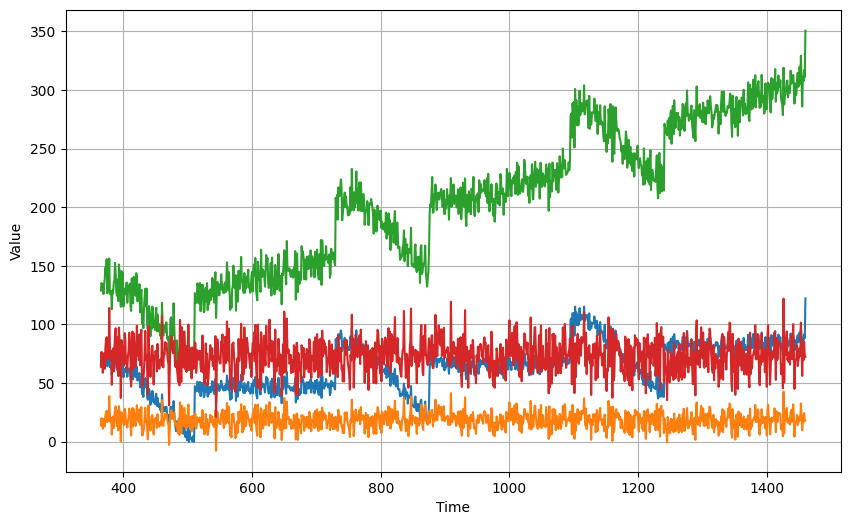

In [52]:
diff_series1 = (series1[365:] - series1[:-365])
diff_series2 = (series2[365:] - series2[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, series1[365:])
plot_series(diff_time, diff_series1)
plot_series(diff_time, series2[365:])
plot_series(diff_time, diff_series2)
plt.show()

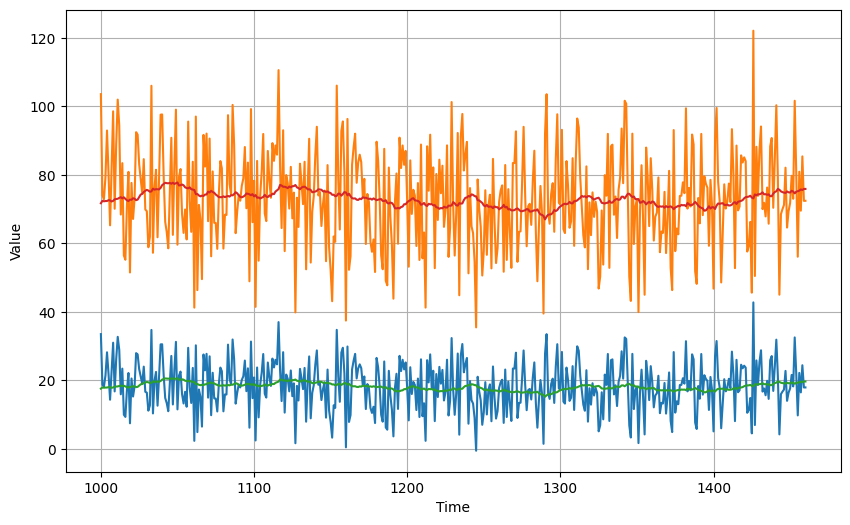

In [53]:
diff_moving_avg1 = moving_average_forecast(diff_series1, 50)[split_time - 365 - 50:]
diff_moving_avg2 = moving_average_forecast(diff_series2, 50)[split_time - 365 - 50:]


plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series1[split_time - 365:])
plot_series(time_valid, diff_series2[split_time - 365:])

#plot_series(time_valid, x_valid)

plot_series(time_valid, diff_moving_avg1)
plot_series(time_valid, diff_moving_avg2)
plt.show()

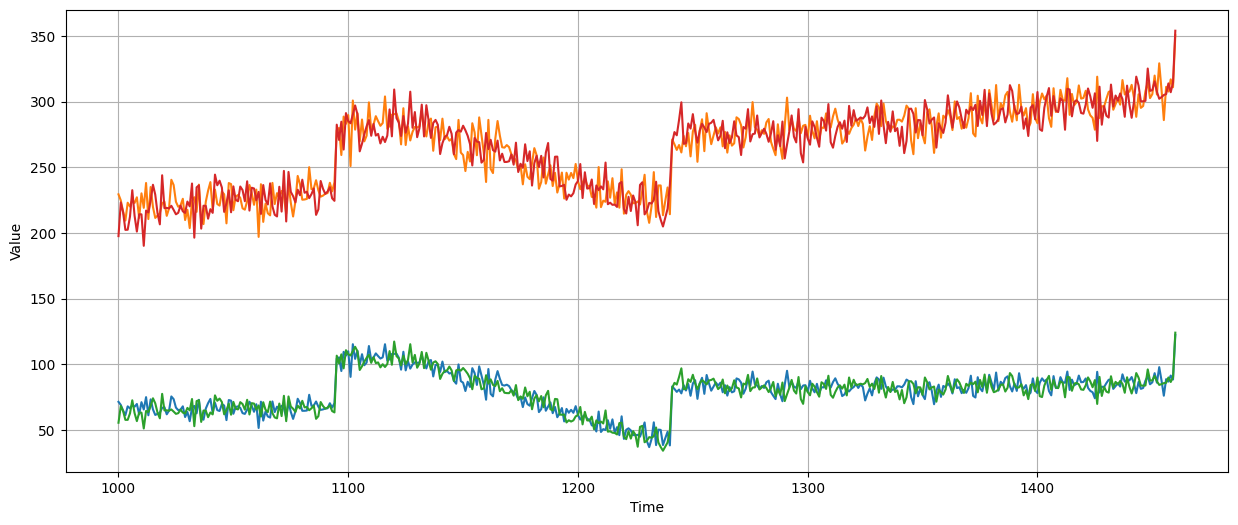

In [54]:
diff_moving_avg_plus_past1 = series1[split_time - 365:-365] + diff_moving_avg1
diff_moving_avg_plus_past2 = series2[split_time - 365:-365] + diff_moving_avg2

plt.figure(figsize=(15, 6))
plot_series(time_valid, x1_valid)
plot_series(time_valid, x2_valid)
plot_series(time_valid, diff_moving_avg_plus_past1)
plot_series(time_valid, diff_moving_avg_plus_past2)
plt.show()

In [63]:
print("\nL'erreur MSE :", keras.metrics.mean_squared_error(x1_valid, diff_moving_avg_plus_past1).numpy())
print("\nL'erreur MAE :", keras.metrics.mean_absolute_error(x1_valid, diff_moving_avg_plus_past1).numpy())



print("\nL'erreur MSE :", keras.metrics.mean_squared_error(x2_valid, diff_moving_avg_plus_past2).numpy())
print("\nL'erreur MAE :", keras.metrics.mean_absolute_error(x2_valid, diff_moving_avg_plus_past2).numpy())


L'erreur MSE : 52.97366

L'erreur MAE : 5.839311

L'erreur MSE : 349.2615

L'erreur MAE : 15.054495
